<a href="https://colab.research.google.com/github/hoangvv5794/NLP-ReviewPhone/blob/main/TGDD_Word2Vec_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import dữ liệu và lib cần thiết**



In [1]:
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt
df= pd.read_csv('https://drive.google.com/uc?id=1G081vomFLNhuasdHwCGumZKdIWE3ZUYz', encoding='utf-8', sep='|')
df.head(3)

,text,label
0,K mục_đích chơi game thi máy khá ổn bin ok,1
1,Rất vừa_tay Màn_hình lớn hiển_thị tốt Trọng_lư...,1
2,Mỗi thứ đều tốt nhưng pin yếu ko đủ sài trong ...,1


In [2]:
tgdd_df = df[['text','label']]
tgdd_df['text'].values

array(['K mục_đích chơi game thi máy khá ổn bin ok',
       'Rất vừa_tay Màn_hình lớn hiển_thị tốt Trọng_lượng nhẹ cầm_nắm tốt _Pin khoẻ _Dùng sương sương được một ngày',
       'Mỗi thứ đều tốt nhưng pin yếu ko đủ sài trong 1 ngày huhu', ...,
       'Tốt sản_phẩm tốt nhất tôi mua sản_phẩm mua khi giảm_giá thì tốt nhưng hk kèm sạc và tai ngje hơi kì nhưng saen phẩm tốt nhất là dsc',
       'Máy cấu_hình tốt dùng rất đã luôn nhưng mình mua xong dùng được một lần duy_nhất hết pin không sạc lại đc vì phụ_kiện đi kèm không tương_thích với củ xạc cũ của Apple',
       'Rất thích các mấu iPhone đẹp gọn sang các ứng_dụng và bảo_mật tốt rất hài_lòng các sản_phẩm iPhone'],
      dtype=object)

**Sử dụng model Word2Vec để pre-trained với thư viện Gensim**

In [4]:
tgdd_text=tgdd_df['text'].values.astype(str)

input_gensim = []
for text in tgdd_text:
    input_gensim.append(text.split())

w2v_model = gensim.models.Word2Vec(input_gensim, size=128, window=5, min_count=10, workers=8)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [5]:
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))


Vocabulary Size: 5478 - Embedding Dim: 128


In [6]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

In [7]:
vocab=w2v_model.wv.vocab

word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  5478


In [8]:
maxi=-1
for i,rev in enumerate(tgdd_text):
  tokens=rev.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)
print(maxi)

646


Chuyển toàn bộ văn bản sang dạng token

In [9]:
enc_dict=[]
for text in tgdd_text:
  enc_text=[]
  tokens=text.split()
  for token in tokens:
    item=word2token(token)
    enc_text.append(item)
  enc_dict.append(enc_text)


In [10]:
print(tgdd_text[0])
print(enc_dict[0])

K mục_đích chơi game thi máy khá ổn bin ok
[1281, 1515, 31, 27, 410, 0, 78, 52, 332, 39]


Chuyển văn bản sang dạng vector

In [13]:
max_rev_len=maxi+1  # max lenght of a review
embed_dim=128 # embedding dimension as choosen in word2vec constructor
# now padding to have a amximum length of 1565
pad_rev= pad_sequences(enc_dict, maxlen=max_rev_len, padding='post')
pad_rev.shape   # note that we had 100K reviews and we have padded each review to have  a lenght of 1565 words.

(29764, 647)

Tạo matrix emmbed

In [14]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word in vocab:
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    index=vocab[word].index
    embed_matrix[index]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

Chia tập train/valid/test

In [23]:
from sklearn.model_selection import train_test_split,cross_validate
from tensorflow.keras.utils import to_categorical


Y=to_categorical(df['label'],num_classes=3)  # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.1,random_state=42)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.20,random_state=42)

**Sử dụng model LSTM**

In [25]:
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 647, 128)          701184    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 843,203
Trainable params: 843,203
Non-trainable params: 0
_________________________________________________________________
None


**Train model LSTM**

In [ ]:
epochs=5
batch_size=32
# fitting the model.
history=model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val,y_val))

Epoch 1/5
670/670 [==============================] - 1197s 2s/step - loss: 0.5874 - accuracy: 0.5467 - val_loss: 0.5908 - val_accuracy: 0.5379
Epoch 2/5
610/670 [==========================>...] - ETA: 1:43 - loss: 0.5862 - accuracy: 0.5486

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.55046546459198 / Test accuracy: 0.7611689567565918


**Vẽ biểu đồ accuracy**

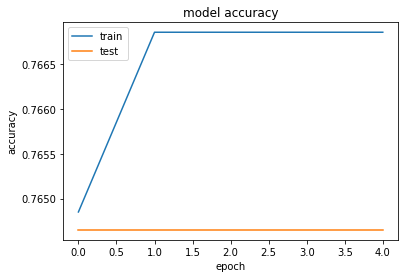

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()